#  Menu-Based Cafeteria Demand Forecasting Model¶


**dataset link:** https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting

# Setup and Libraries

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import shap

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Evaluation Metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Models
from lightgbm import LGBMRegressor, log_evaluation
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold

# Hyperparameter Optimization
import optuna

# LightGBM Utilities
from lightgbm import early_stopping, log_evaluation

# Settings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

import os
for dirname, _, filenames in os.walk('/kaggle/input/food-demand-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/food-demand-forecasting/meal_info.csv
/kaggle/input/food-demand-forecasting/sample_submission.csv
/kaggle/input/food-demand-forecasting/fulfilment_center_info.csv
/kaggle/input/food-demand-forecasting/train.csv
/kaggle/input/food-demand-forecasting/test.csv


## PART 1: Data Preprocessing and Analysis

Project data was loaded and checked for missing values using the quick_inspect function. Separate files for meals, centers, and orders were merged into a single MASTER_TRAIN table using meal_id and center_id. This integration allows the model to analyze the combined effects of category, price, and location on demand. Infinite values were cleared to ensure data integrity. This stage was completed to prepare the raw data for feature engineering. As a result, a clean and organized data structure was created for high-quality predictions.

In [2]:
BASE_PATH = "/kaggle/input/food-demand-forecasting/"

train = pd.read_csv(BASE_PATH + "train.csv")
meal_info = pd.read_csv(BASE_PATH + "meal_info.csv")
center_info = pd.read_csv(BASE_PATH + "fulfilment_center_info.csv")

def quick_inspect(df, name):
    print(f"\n\n===== {name} =====")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nDtypes:\n", df.dtypes)
    print("\nMissing values:\n", df.isna().sum())
    print("\nHead:")
    display(df.head())

quick_inspect(train, "TRAIN")
quick_inspect(meal_info, "MEAL_INFO")
quick_inspect(center_info, "FULFILMENT_CENTER_INFO")



===== TRAIN =====
Shape: (456548, 9)
Columns: ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders']

Dtypes:
 id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
dtype: object

Missing values:
 id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

Head:


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40




===== MEAL_INFO =====
Shape: (51, 3)
Columns: ['meal_id', 'category', 'cuisine']

Dtypes:
 meal_id      int64
category    object
cuisine     object
dtype: object

Missing values:
 meal_id     0
category    0
cuisine     0
dtype: int64

Head:


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian




===== FULFILMENT_CENTER_INFO =====
Shape: (77, 5)
Columns: ['center_id', 'city_code', 'region_code', 'center_type', 'op_area']

Dtypes:
 center_id        int64
city_code        int64
region_code      int64
center_type     object
op_area        float64
dtype: object

Missing values:
 center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

Head:


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [3]:
# Merge train with meal_info on meal_id
train_merged = train.merge(meal_info, on="meal_id", how="left")

# Merge result with center_info on center_id
master_train = train_merged.merge(center_info, on="center_id", how="left")
master_train = master_train.replace([np.inf, -np.inf], np.nan)


print("MASTER_TRAIN shape:", master_train.shape)
print("Missing values in MASTER_TRAIN:")
print(master_train.isna().sum())

display(master_train.head())

MASTER_TRAIN shape: (456548, 15)
Missing values in MASTER_TRAIN:
id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


The columns in the dataset were grouped according to their types in order to allow an effective analysis. In the dataset, the number of orders and price variables are unbalanced and show right-skewed distributions with clear outliers. While orders are concentrated on a small number of products, demand is observed to decrease as prices increase. Variables such as category, region, and center type are found to have a strong impact on order volume. Products that are promoted or featured on the homepage are seen to receive higher numbers of orders. Because of this unbalanced structure, applying a log transformation to the order quantity and using tree-based models are considered to produce more reliable results.

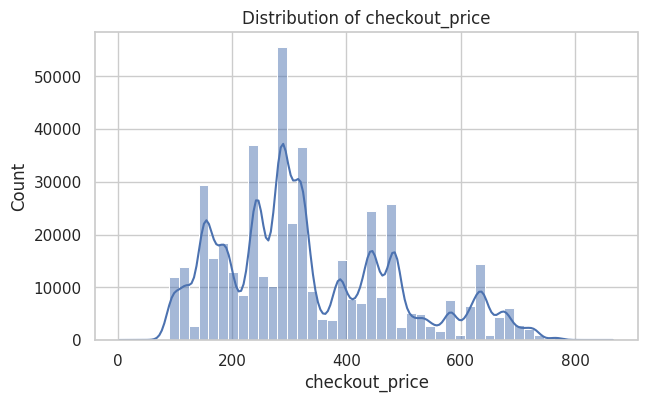

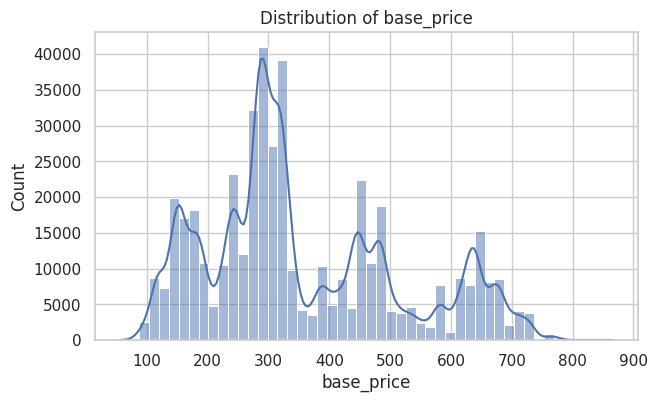

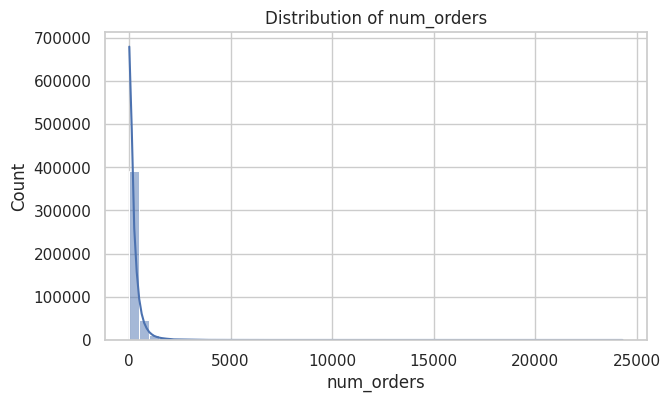

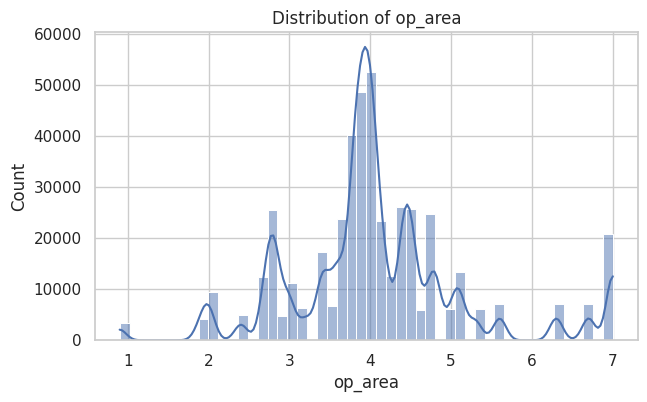

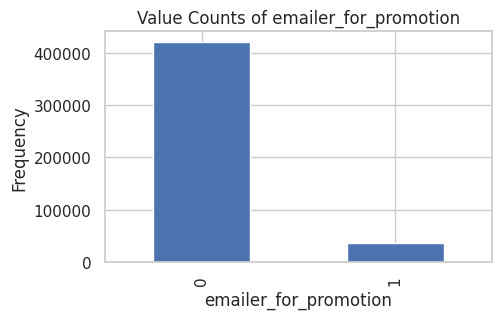

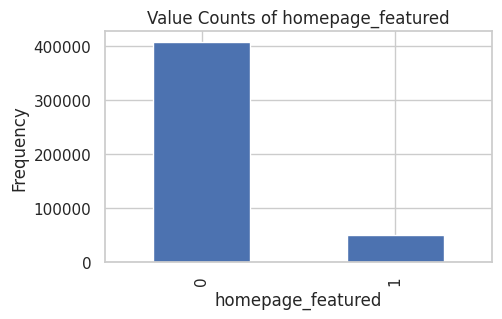

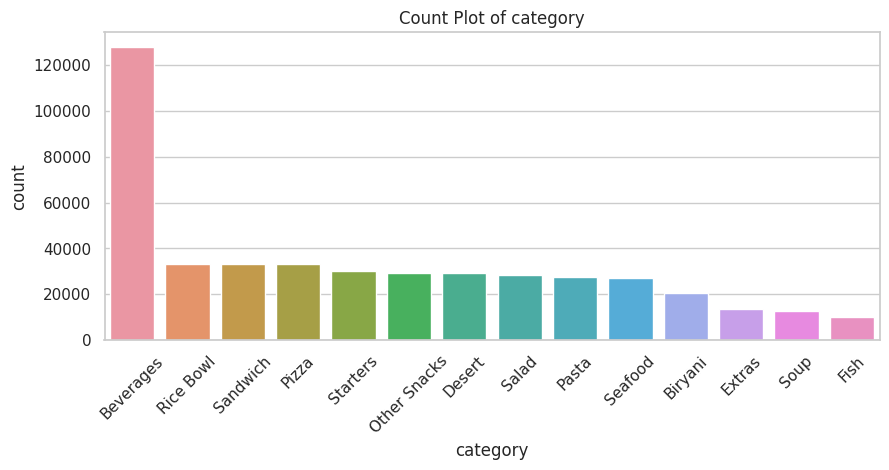

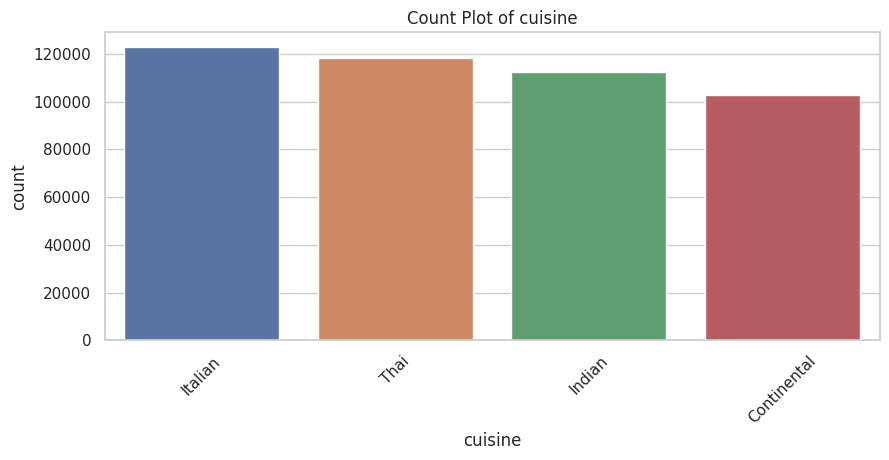

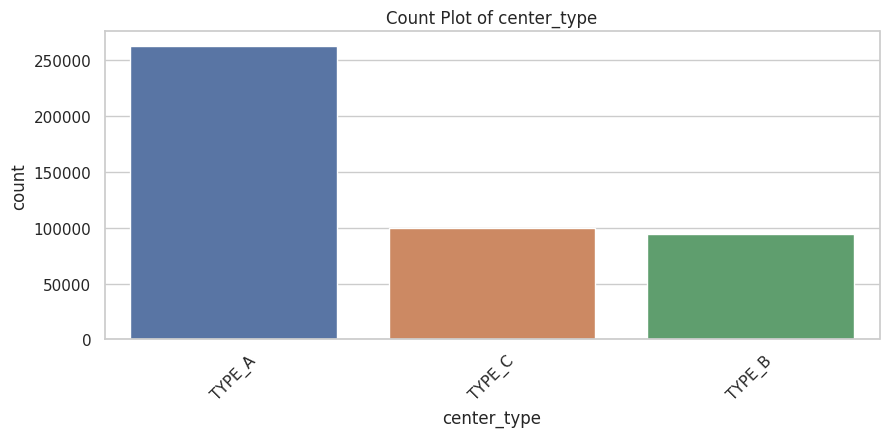

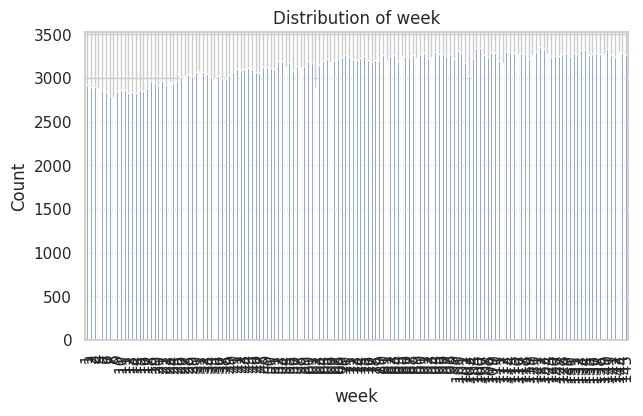

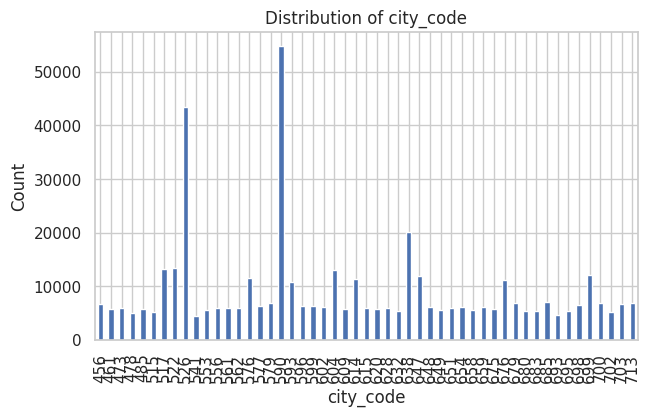

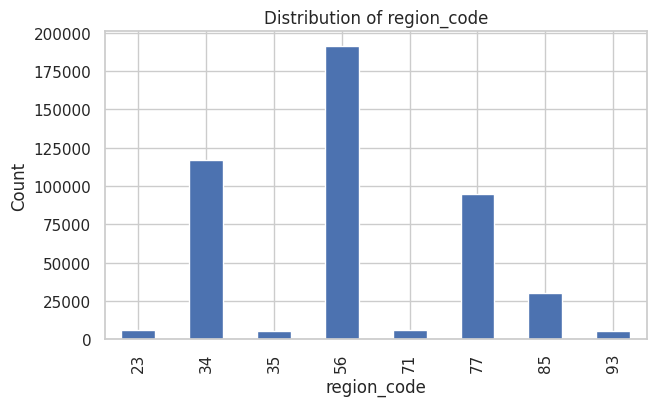

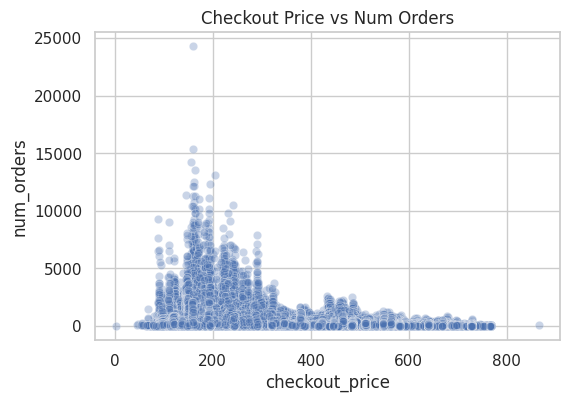

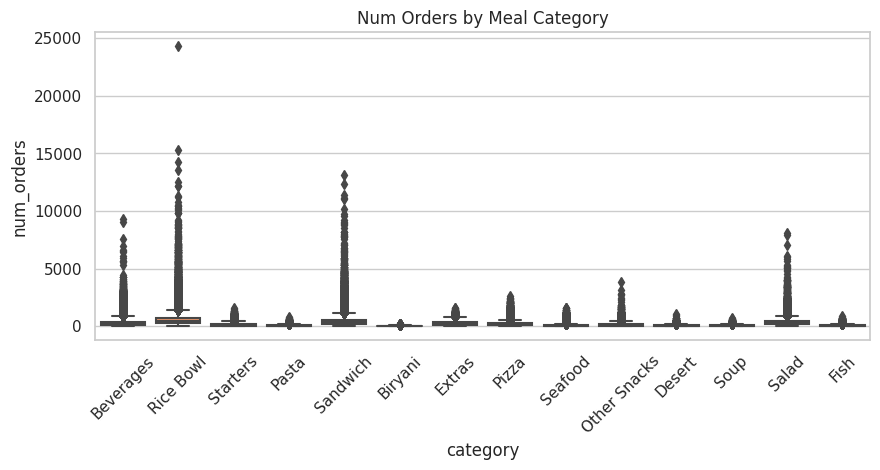

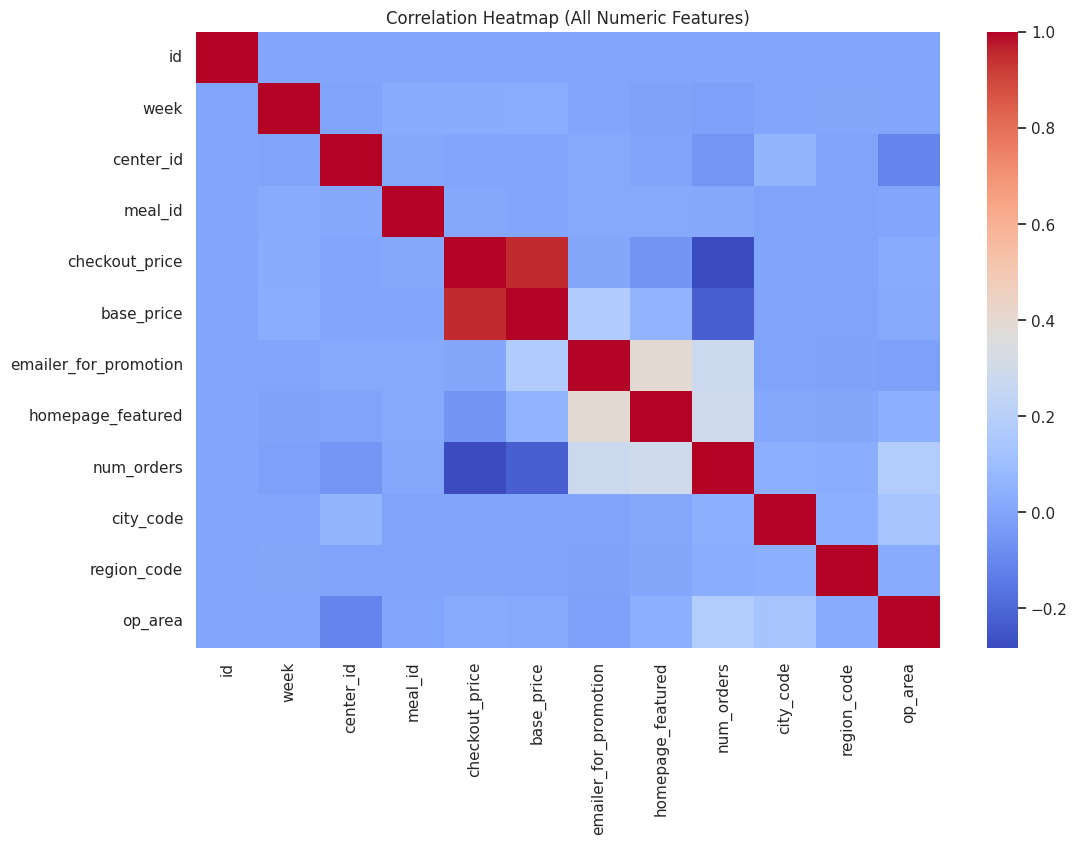

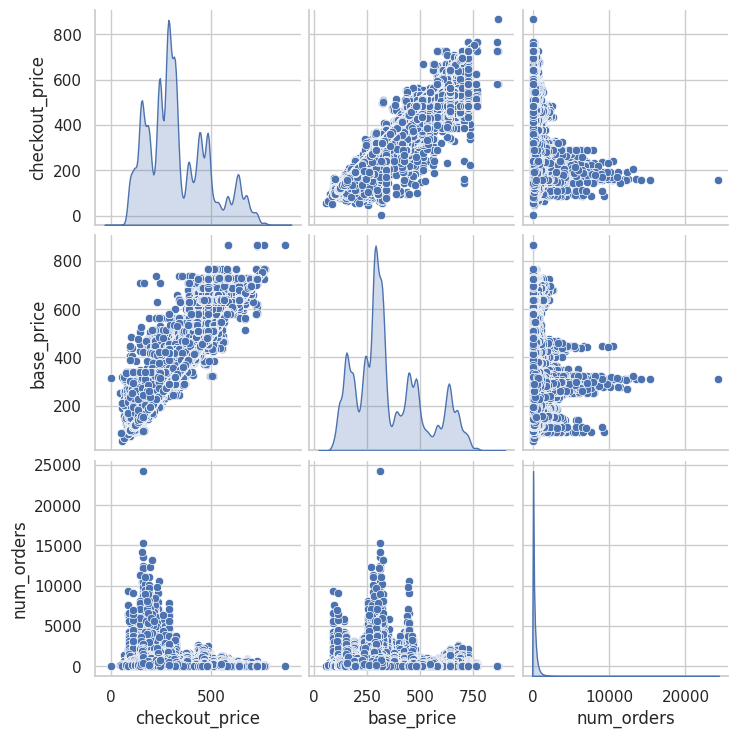

In [6]:
# =============== FEATURE GROUPING =====================

# Continuous numeric columns
continuous_cols = ['checkout_price', 'base_price', 'num_orders', 'op_area']

# Binary features
binary_cols = ['emailer_for_promotion', 'homepage_featured']

# Categorical (string/object)
categorical_cols = ['category', 'cuisine', 'center_type']

# Numeric categorical-like (codes/IDs)
numeric_categorical_cols = ['week', 'city_code', 'region_code']

# =============== 1. CONTINUOUS NUMERIC DISTRIBUTIONS =====================

for col in continuous_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(master_train[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# =============== 2. BINARY FEATURE BARPLOTS =====================

for col in binary_cols:
    plt.figure(figsize=(5,3))
    master_train[col].value_counts().plot(kind='bar')
    plt.title(f"Value Counts of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# =============== 3. CATEGORICAL FEATURE COUNTPLOTS =====================

for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=master_train, x=col, order=master_train[col].value_counts().index)
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

# =============== 4. NUMERIC CATEGORICAL-LIKE DISTRIBUTIONS =====================

for col in numeric_categorical_cols:
    plt.figure(figsize=(7,4))
    master_train[col].value_counts().sort_index().plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# =============== 5. TARGET RELATIONSHIPS =====================

# A) Scatter: price vs num_orders
plt.figure(figsize=(6,4))
sns.scatterplot(x=master_train['checkout_price'], y=master_train['num_orders'], alpha=0.3)
plt.title("Checkout Price vs Num Orders")
plt.show()

# B) Boxplot: category vs num_orders
plt.figure(figsize=(10,4))
sns.boxplot(data=master_train, x='category', y='num_orders')
plt.title("Num Orders by Meal Category")
plt.xticks(rotation=45)
plt.show()

# =============== 6. CORRELATION HEATMAP =====================

plt.figure(figsize=(12,8))
sns.heatmap(master_train[continuous_cols].corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (Continuous Features)")
plt.show()

# =============== 7. LIGHT PAIRPLOT (ONLY KEY FEATURES) =====================

sns.pairplot(master_train[['checkout_price','base_price','num_orders']], diag_kind="kde")
plt.show()


At this stage, the general structure of the dataset was analyzed by examining the distributions and basic statistics before applying any outlier handling. Then, three different methods were applied to reduce the effect of outliers: IQR capping, log transformation, and a hybrid method that combines both approaches. While extreme values were limited within certain boundaries using the IQR method, log transformation was mainly applied to the number of orders variable, which has a highly right-skewed distribution. In the hybrid approach, the most suitable method was selected for each variable in order to obtain a more balanced data structure. Boxplots and histograms were visualized side by side to compare the effects of these methods. Based on these comparisons, the hybrid approach was expected to provide better results.

,num_orders,checkout_price,base_price
count,456548.000000,456548.000000,456548.000000
mean,261.872760,332.238933,354.156627
std,395.922798,152.939723,160.715914
min,13.000000,2.970000,55.350000
25%,54.000000,228.950000,243.500000
50%,136.000000,296.820000,310.460000
75%,324.000000,445.230000,458.870000
max,24299.000000,866.270000,866.270000


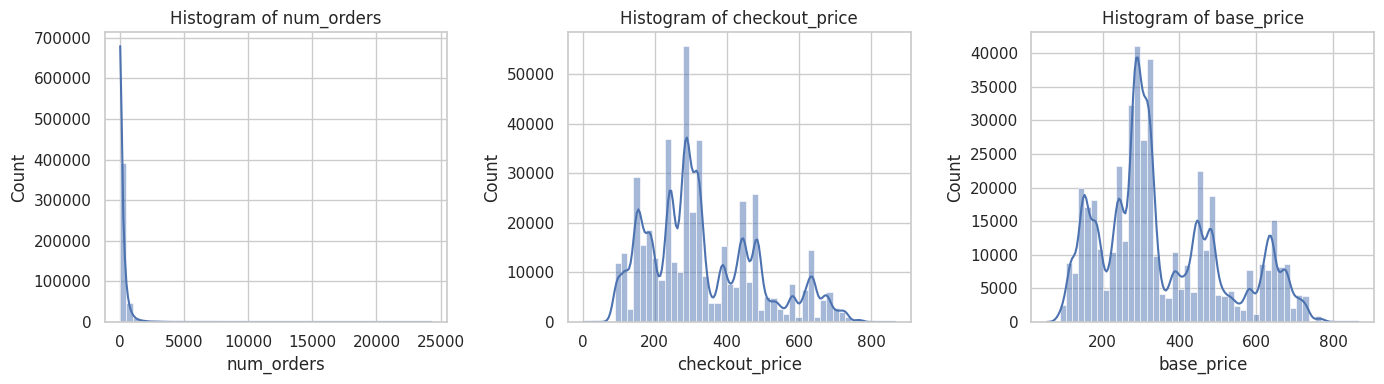

In [7]:
# Summary statistics (only numeric meaningful columns)
display(master_train[['num_orders', 'checkout_price', 'base_price']].describe())

# Histograms
numeric_cols = ['num_orders', 'checkout_price', 'base_price']

plt.figure(figsize=(14,4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(master_train[col], bins=50, kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

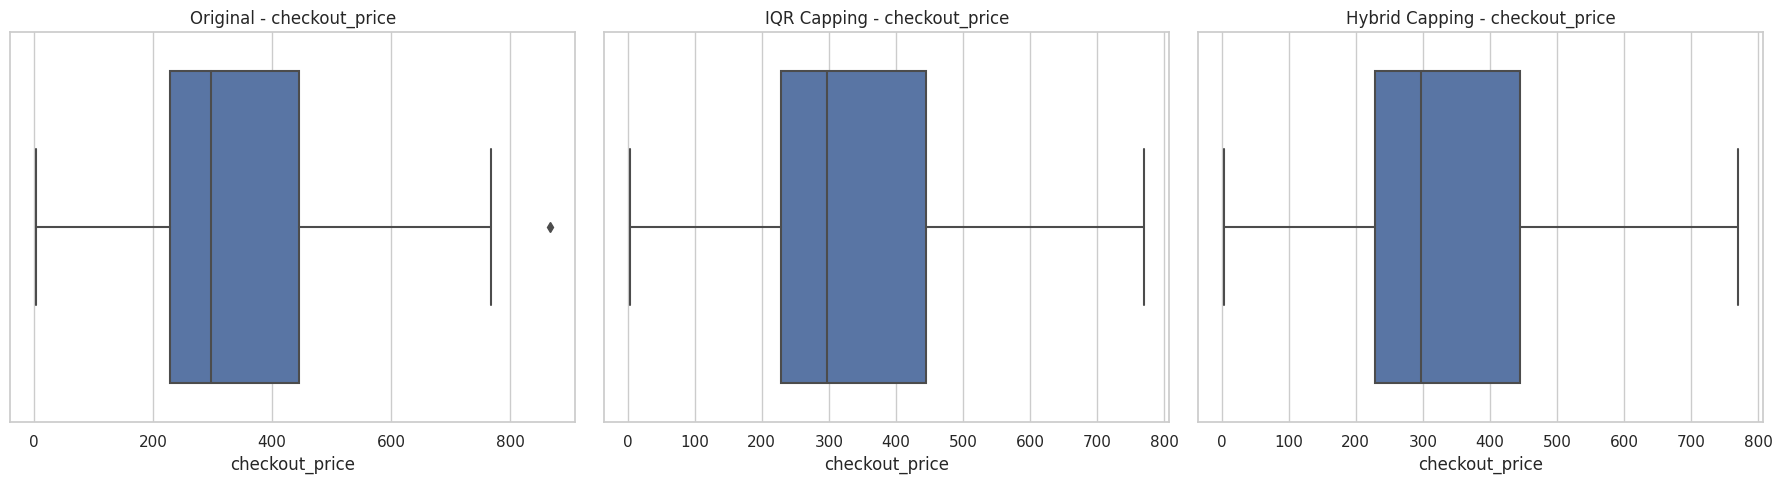

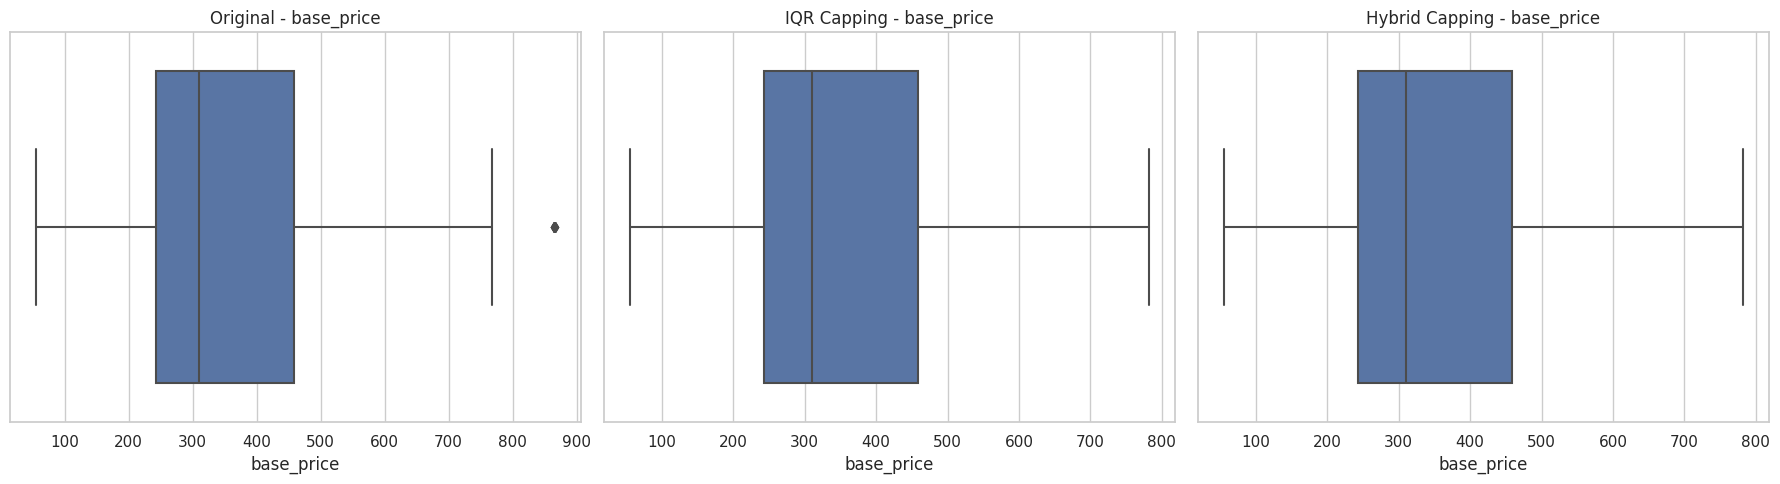

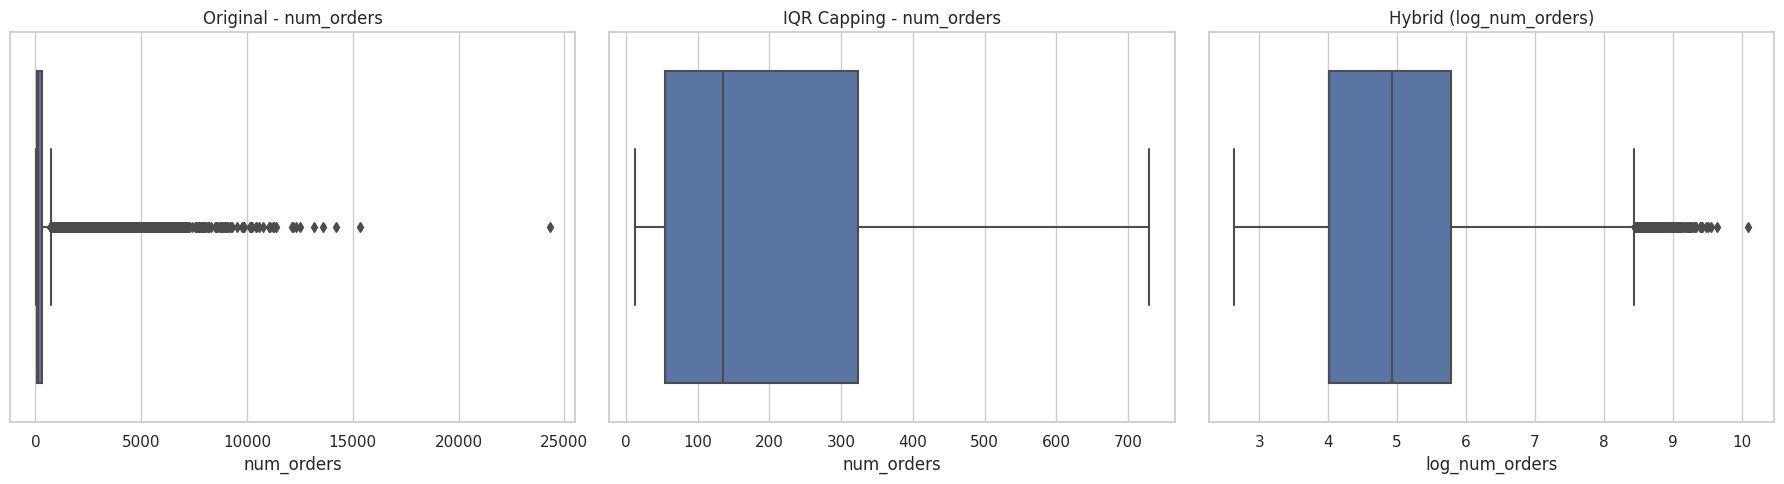

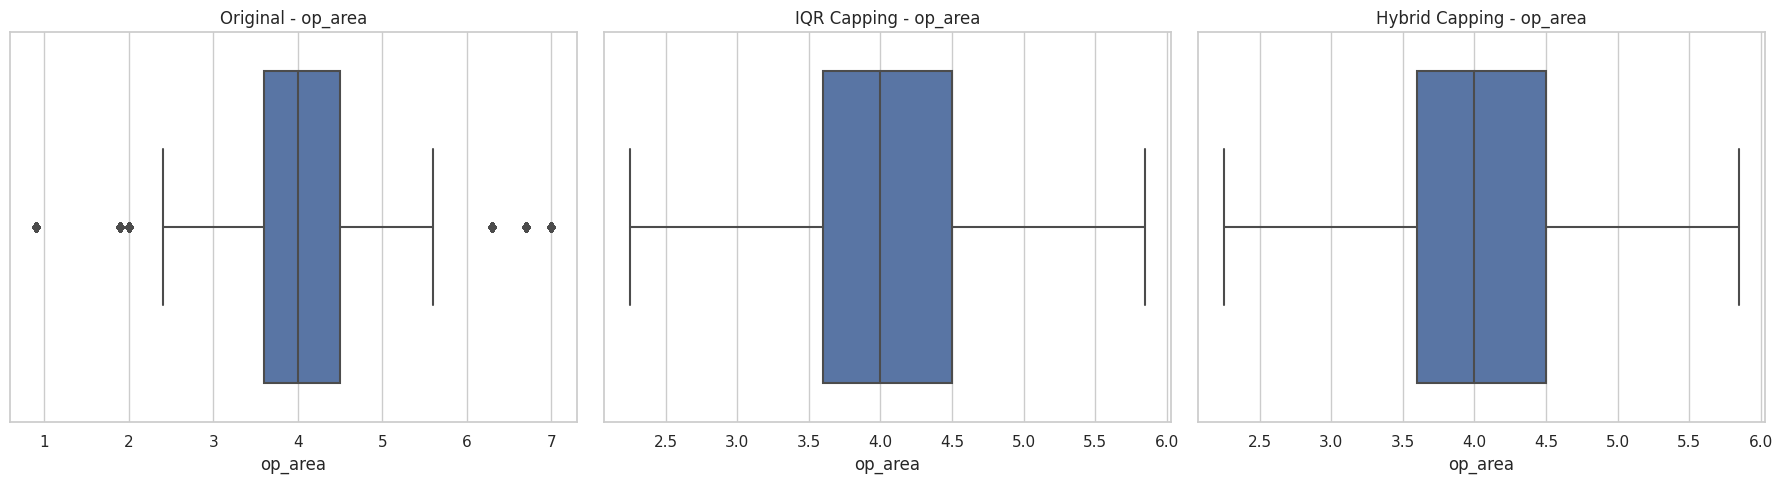

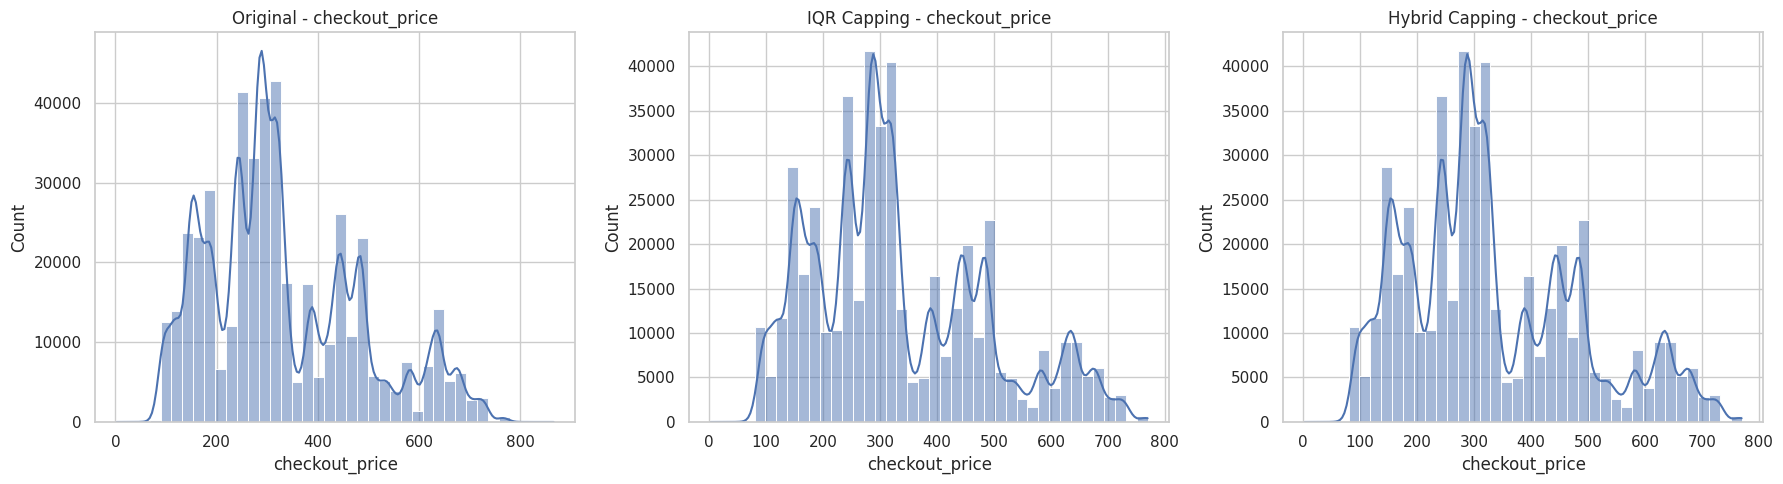

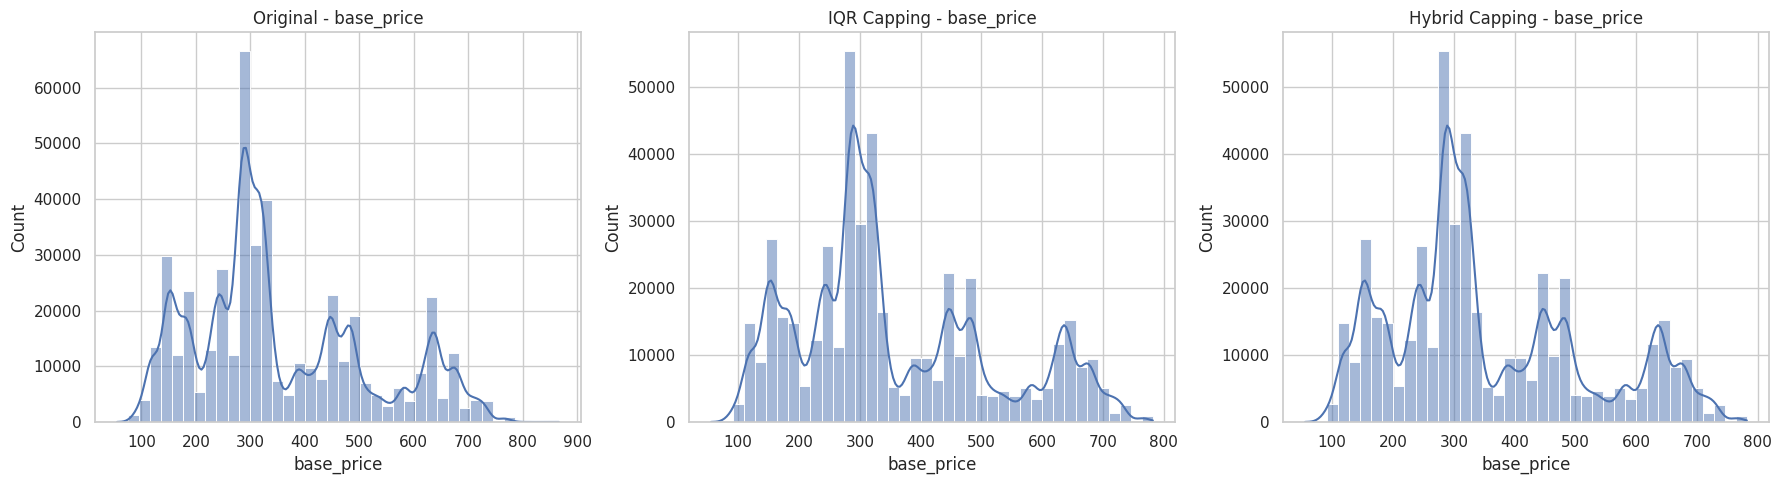

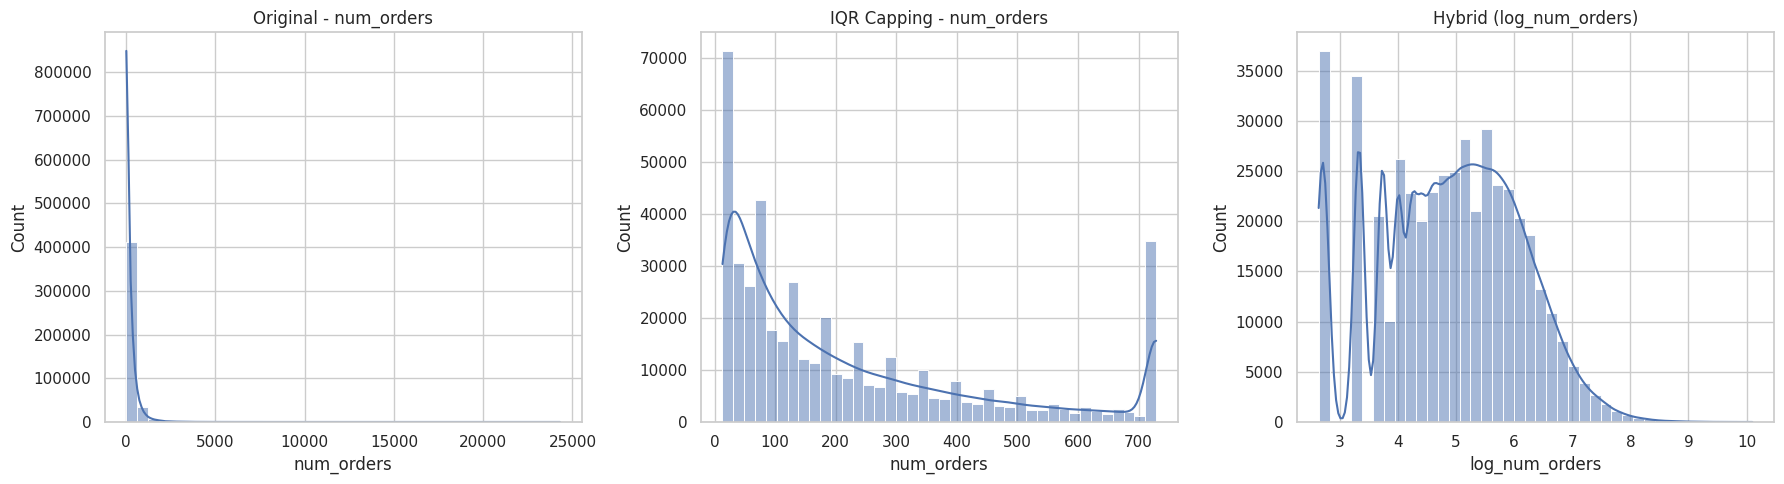

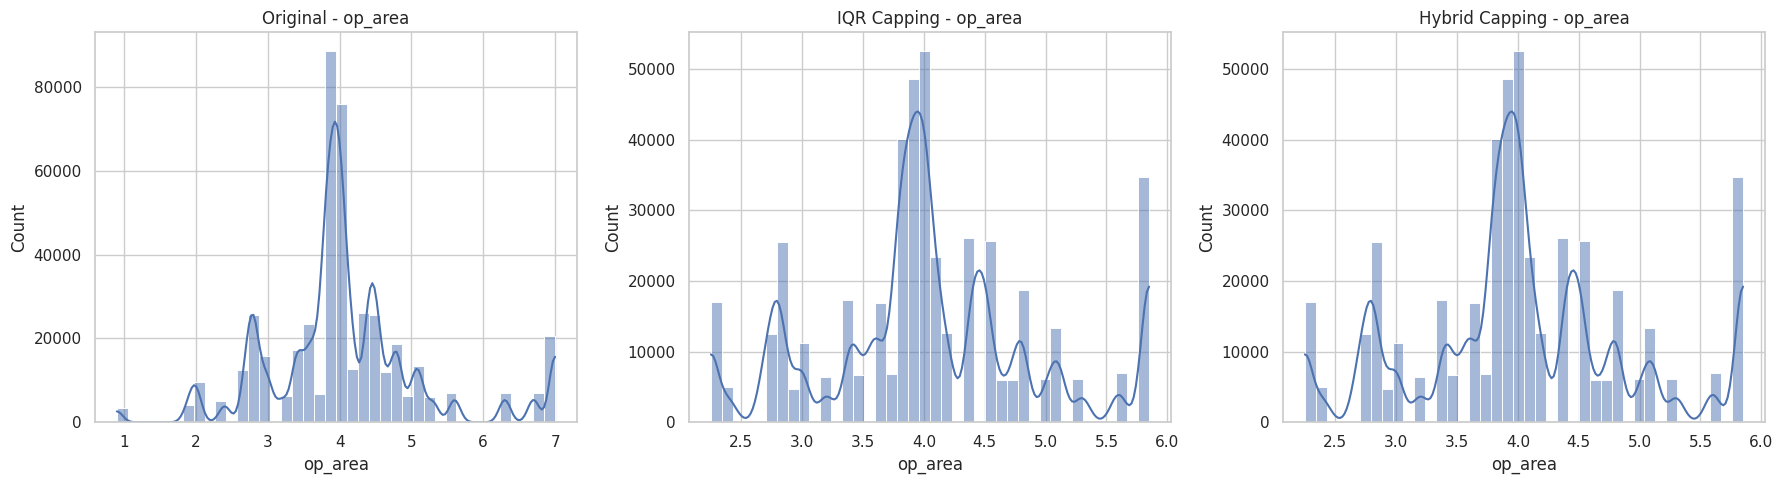

In [8]:
# Original data
df_original = master_train.copy()

# ============================
# METHOD 1 — IQR CAPPING
# ============================
df_outlier_iqr = master_train.copy()

for col in ['checkout_price', 'base_price', 'num_orders', 'op_area']:
    Q1 = df_outlier_iqr[col].quantile(0.25)
    Q3 = df_outlier_iqr[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_outlier_iqr[col] = df_outlier_iqr[col].clip(lower=lower, upper=upper)


# ============================
# METHOD 2 — LOG TRANSFORM
# ============================
df_outlier_log = master_train.copy()

# Only positive features get log
for col in ['checkout_price', 'base_price', 'num_orders']:
    df_outlier_log[f'log_{col}'] = np.log1p(df_outlier_log[col])


# ============================
# METHOD 3 — HYBRID (BEST)
# ============================
df_outlier_hybrid = master_train.copy()

# Capping for these features
cap_cols = ['checkout_price', 'base_price', 'op_area']
for col in cap_cols:
    Q1 = df_outlier_hybrid[col].quantile(0.25)
    Q3 = df_outlier_hybrid[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_outlier_hybrid[col] = df_outlier_hybrid[col].clip(lower=lower, upper=upper)

# log transform for num_orders
df_outlier_hybrid['log_num_orders'] = np.log1p(df_outlier_hybrid['num_orders'])


# ============================
# SIDE-BY-SIDE PLOTS
# ============================

features_to_plot = ['checkout_price', 'base_price', 'num_orders', 'op_area']

for col in features_to_plot:
    plt.figure(figsize=(18, 5))

    # ORIGINAL
    plt.subplot(1, 3, 1)
    sns.boxplot(x=df_original[col])
    plt.title(f"Original - {col}")

    # IQR
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df_outlier_iqr[col])
    plt.title(f"IQR Capping - {col}")

    # HYBRID or LOG depending on feature
    plt.subplot(1, 3, 3)
    if col == 'num_orders':
        sns.boxplot(x=df_outlier_hybrid['log_num_orders'])
        plt.title(f"Hybrid (log_num_orders)")
    else:
        sns.boxplot(x=df_outlier_hybrid[col])
        plt.title(f"Hybrid Capping - {col}")

    plt.tight_layout()
    plt.show()


# ============================
# ALSO SHOW HISTOGRAMS
# ============================

for col in features_to_plot:
    plt.figure(figsize=(18, 5))

    # ORIGINAL
    plt.subplot(1, 3, 1)
    sns.histplot(df_original[col], bins=40, kde=True)
    plt.title(f"Original - {col}")

    # IQR
    plt.subplot(1, 3, 2)
    sns.histplot(df_outlier_iqr[col], bins=40, kde=True)
    plt.title(f"IQR Capping - {col}")

    # HYBRID or LOG depending on feature
    plt.subplot(1, 3, 3)
    if col == 'num_orders':
        sns.histplot(df_outlier_hybrid['log_num_orders'], bins=40, kde=True)
        plt.title("Hybrid (log_num_orders)")
    else:
        sns.histplot(df_outlier_hybrid[col], bins=40, kde=True)
        plt.title(f"Hybrid Capping - {col}")

    plt.tight_layout()
    plt.show()

## Part 2: Modeling and Evaluation


The code applies one-hot encoding to categorical variables so that different datasets can be used in a consistent way. First, all datasets are combined to make sure the same categories are encoded together. After encoding, the combined data is separated back into the original datasets with the same column structure. Then, correlations between all variables are calculated for one dataset. Finally, these correlations are visualized using a heatmap to observe relationships between variables and possible strong dependencies.

In [9]:
def one_hot_encode_multiple_dfs(dfs, categorical_cols, drop_first=False):
    combined = pd.concat(dfs.values(), axis=0)

    combined_encoded = pd.get_dummies(
        combined,
        columns=categorical_cols,
        drop_first=drop_first
    )

    encoded_dfs = {}
    start_idx = 0

    for name, df in dfs.items():
        end_idx = start_idx + len(df)
        encoded_dfs[name] = combined_encoded.iloc[start_idx:end_idx].reset_index(drop=True)
        start_idx = end_idx

    return encoded_dfs

In [10]:
# for 3 different df (df_outlier_iqr, df_outlier_log, df_outlier_hybrid ) one hot encoding

categorical_cols = ['category', 'cuisine', 'center_type']

dfs = {
    'iqr': df_outlier_iqr,
    'log': df_outlier_log,
    'hybrid': df_outlier_hybrid
}

encoded_dfs = one_hot_encode_multiple_dfs(
    dfs=dfs,
    categorical_cols=categorical_cols,
    drop_first=False
)

df_iqr_ohe = encoded_dfs['iqr']
df_log_ohe = encoded_dfs['log']
df_hybrid_ohe = encoded_dfs['hybrid']

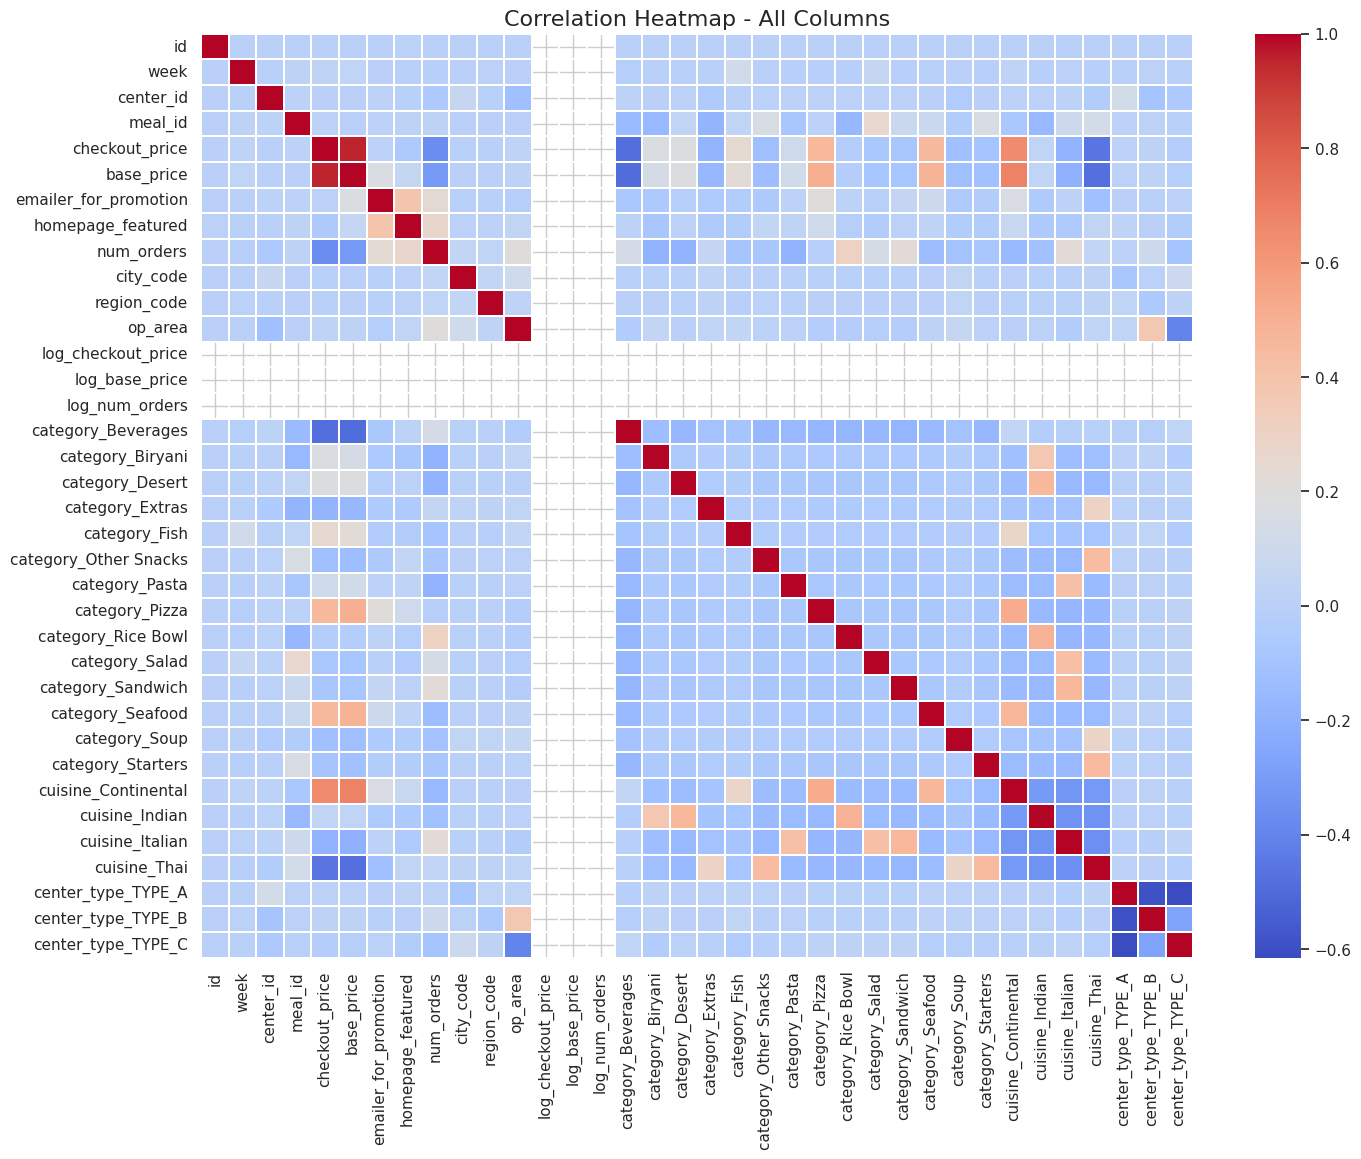

In [11]:
# heatmap
plt.figure(figsize=(16,12))  
corr = df_iqr_ohe.corr()

sns.heatmap(
    corr,
    annot=False,       
    cmap="coolwarm",
    linewidths=0.3
)

plt.title("Correlation Heatmap - All Columns", fontsize=16)
plt.show()

In [12]:
!pip install optuna lightgbm

In this part, a comprehensive modeling process was carried out using datasets prepared with different outlier handling methods. Before modeling, additional features such as price-related variables, discount features, and time-based lag and rolling average variables were created. The data was then split into training and validation sets based on time, and categorical variables were encoded appropriately. After that, performance comparisons were conducted using linear regression, tree-based models, and advanced boosting models. Finally, the results of all model and dataset combinations were evaluated and visualized using R² and RMSE metrics.


Modeling starts for IQR Data
----------------------------------------
Train set: 361348 rows
Validation set: 95200 rows
----------------------------------------
----------------------------------------
Training Linear Regression...
   Linear Regression -> R2: 0.8441, RMSE: 82.8446
----------------------------------------
Training Decision Tree...
   Decision Tree -> R2: 0.8343, RMSE: 85.4025
----------------------------------------
Training Random Forest...
   Random Forest -> R2: 0.8630, RMSE: 77.6478
----------------------------------------
Training LightGBM...
   LightGBM -> R2: 0.8649, RMSE: 77.1027
----------------------------------------
Training XGBoost...
   XGBoost -> R2: 0.8560, RMSE: 79.6000
----------------------------------------
Training CatBoost...
   CatBoost -> R2: 0.8689, RMSE: 75.9547

Modeling starts for Log Data
----------------------------------------
Train set: 361348 rows
Validation set: 95200 rows
----------------------------------------
----------------------

,Dataset,Model,RMSE,R2
5,IQR Data,CatBoost,75.954681,0.868921
3,IQR Data,LightGBM,77.102704,0.864929
2,IQR Data,Random Forest,77.647838,0.863012
4,IQR Data,XGBoost,79.599994,0.856037
0,IQR Data,Linear Regression,82.844595,0.844062
17,Hybrid Data,CatBoost,144.869711,0.842649
11,Log Data,CatBoost,145.172332,0.841991
1,IQR Data,Decision Tree,85.402488,0.834284
9,Log Data,LightGBM,148.851663,0.833880
15,Hybrid Data,LightGBM,149.899966,0.831532


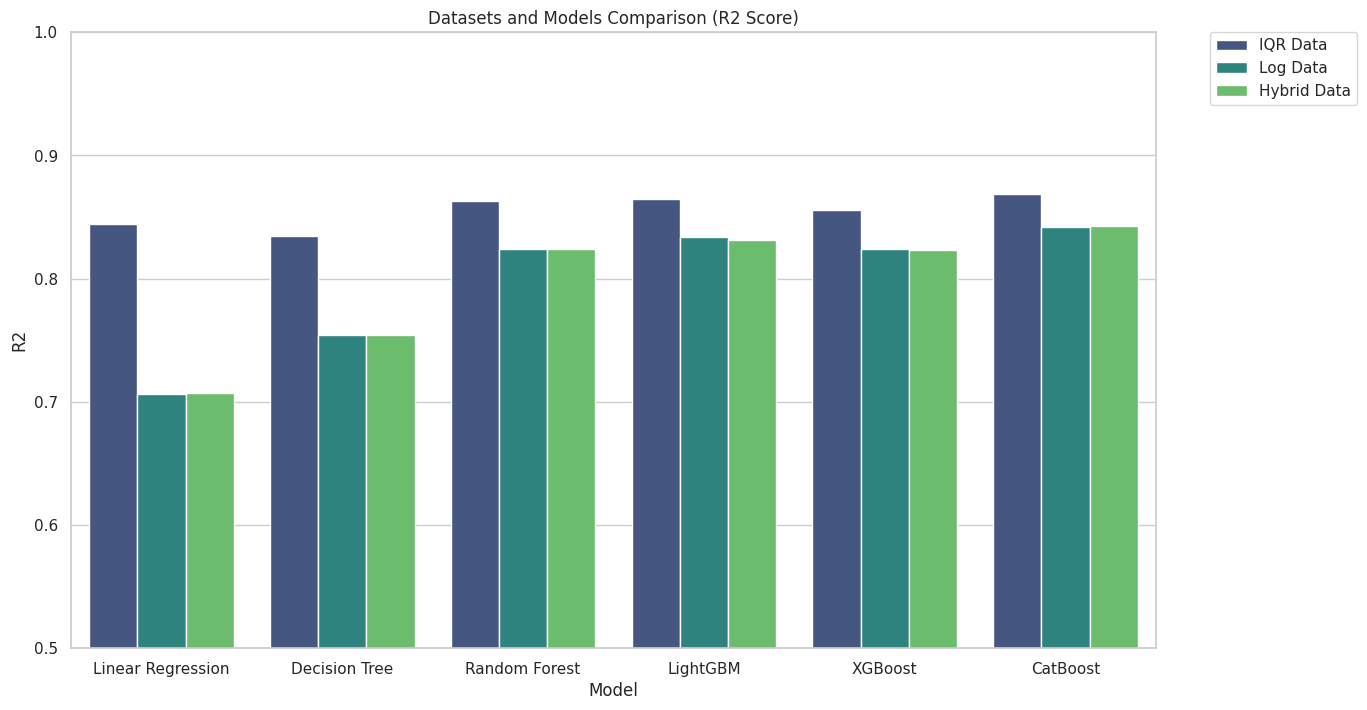

In [13]:
warnings.filterwarnings('ignore')

# modeling
def modeling(df_input, dataset_name):
    print(f"\n{'='*40}")
    print(f"Modeling starts for {dataset_name}")
    print(f"{'='*40}")

    df = df_input.copy()

    if 'base_price' in df.columns and 'checkout_price' in df.columns:
        df['discount_amount'] = df['base_price'] - df['checkout_price']
        df['discount_ratio'] = df['discount_amount'] / df['base_price']
        df['price_per_area'] = df['checkout_price'] / df['op_area']

    df = df.sort_values(by=['center_id', 'meal_id', 'week'])

    df['lag_1'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(1)
    df['lag_2'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(2)
    df['rolling_mean_4'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform(
        lambda x: x.shift(1).rolling(window=4).mean()
    )

    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)

    categorical_cols = ['category', 'cuisine', 'center_type']
    existing_cats = [c for c in categorical_cols if c in df.columns]
    if existing_cats:
        df = pd.get_dummies(df, columns=existing_cats, dtype=int)

    df['center_meal_pair'] = df['center_id'].astype(str) + '_' + df['meal_id'].astype(str)

    df['avg_price_last_4_weeks'] = df.groupby(['center_id', 'meal_id'])['checkout_price'].transform(
        lambda x: x.shift(1).rolling(window=4).mean())
    df['price_momentum'] = df['checkout_price'] / df['avg_price_last_4_weeks']
    df['price_momentum'] = df['price_momentum'].fillna(1)
    df['avg_price_last_4_weeks'] = df['avg_price_last_4_weeks'].fillna(df['checkout_price'])

    df = df.sort_values(by=['center_id', 'meal_id', 'week'])
    df['lag_52'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(52)
    df['lag_26'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(26)
    df['rolling_mean_13'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform(
        lambda x: x.shift(1).rolling(window=13).mean())

    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.bfill().fillna(0)

    df.columns = df.columns.str.replace(' ', '_')

    # TIME-BASED SPLIT
    df_sorted = df.sort_values('week')
    total_weeks = df_sorted['week'].nunique()
    train_weeks = int(total_weeks * 0.8)
    max_train_week = df_sorted['week'].unique()[train_weeks - 1]

    train = df_sorted[df_sorted['week'] <= max_train_week].copy()
    val = df_sorted[df_sorted['week'] > max_train_week].copy()

    print("-"*40)
    print(f"Train set: {len(train)} rows")
    print(f"Validation set: {len(val)} rows")
    print("-"*40)

    # Target Encoding
    cols_to_encode = ['center_meal_pair', 'meal_id']
    for col in cols_to_encode:
        if col in train.columns:
            means = train.groupby(col)['num_orders'].mean()
            new_col = col + '_target_mean'

            train[new_col] = train[col].map(means)
            val[new_col] = val[col].map(means)

            global_mean = train['num_orders'].mean()
            train[new_col] = train[new_col].fillna(global_mean)
            val[new_col] = val[new_col].fillna(global_mean)

    drop_cols = ['num_orders', 'id', 'center_meal_pair', 'log_num_orders']
    drop_cols = [c.replace(' ', '_') for c in drop_cols]

    X_train = train.drop(columns=drop_cols, errors='ignore')
    y_train = train['num_orders']
    X_val = val.drop(columns=drop_cols, errors='ignore')
    y_val = val['num_orders']

    models = {
        "Linear Regression": LinearRegression(),

        "Decision Tree": DecisionTreeRegressor(
            max_depth=12,
            min_samples_split=20,
            random_state=42
        ),

        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            n_jobs=-1,
            random_state=42
        ),

        "LightGBM": LGBMRegressor(
            n_estimators=3000,
            learning_rate=0.02,
            max_depth=12,
            num_leaves=50,
            subsample=0.7,
            colsample_bytree=0.7,
            metric='rmse',
            n_jobs=-1,
            random_state=42,
            verbosity=-1,
            force_col_wise=True
        ),

        "XGBoost": XGBRegressor(
            n_estimators=3000,
            learning_rate=0.02,
            max_depth=10,
            tree_method='hist',
            n_jobs=-1,
            random_state=42
        ),

        "CatBoost": CatBoostRegressor(
            iterations=3000,
            learning_rate=0.02,
            depth=8,
            loss_function='RMSE',
            eval_metric='R2',
            early_stopping_rounds=100,
            verbose=0,
            allow_writing_files=False,
            random_seed=42
        )
    }

    dataset_results = []


    for name, model in models.items():
        print("-"*40)
        print(f"Training {name}...")

        if name == "LightGBM":
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[log_evaluation(period=0)]
            )
        elif name == "XGBoost":
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        elif name == "CatBoost":
            model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
        else:
            model.fit(X_train, y_train)

        preds = model.predict(X_val)
        preds = np.maximum(0, preds)

        rmse = mean_squared_error(y_val, preds, squared=False)
        r2 = r2_score(y_val, preds)

        dataset_results.append({
            "Dataset": dataset_name,
            "Model": name,
            "RMSE": rmse,
            "R2": r2
        })
        print(f"   {name} -> R2: {r2:.4f}, RMSE: {rmse:.4f}")

    return dataset_results

target_datasets = {
    "IQR Data": df_iqr_ohe,
    "Log Data": df_log_ohe,
    "Hybrid Data": df_hybrid_ohe
}

final_results = []

for name, df in target_datasets.items():
    res = modeling(df, name)
    final_results.extend(res)


df_final_results = pd.DataFrame(final_results)

print("\n" + "="*50)
print("RESULTS")
print("="*50)
display(df_final_results.sort_values(by="R2", ascending=False))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.barplot(data=df_final_results, x="Model", y="R2", hue="Dataset", palette="viridis")
plt.title("Datasets and Models Comparison (R2 Score)")
plt.ylim(0.5, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In this part, an ensemble model was tested; however, its performance remained behind the best-performing model.

In [14]:
#ensemble
df = df_iqr_ohe.copy()

#same operations for modeling

if 'base_price' in df.columns and 'checkout_price' in df.columns:
    df['discount_amount'] = df['base_price'] - df['checkout_price']
    df['discount_ratio'] = df['discount_amount'] / df['base_price']
    df['price_per_area'] = df['checkout_price'] / df['op_area']

df = df.sort_values(by=['center_id', 'meal_id', 'week'])

df['lag_1'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(1)
df['lag_2'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(2)
df['rolling_mean_4'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform(
    lambda x: x.shift(1).rolling(window=4).mean()
)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

categorical_cols = ['category', 'cuisine', 'center_type']
existing_cats = [c for c in categorical_cols if c in df.columns]
if existing_cats:
    print(f"   -> Applying One-Hot Encoding to: {existing_cats}")
    df = pd.get_dummies(df, columns=existing_cats, dtype=int)

df['center_meal_pair'] = df['center_id'].astype(str) + '_' + df['meal_id'].astype(str)

df['avg_price_last_4_weeks'] = df.groupby(['center_id', 'meal_id'])['checkout_price'].transform(
    lambda x: x.shift(1).rolling(window=4).mean())

df['price_momentum'] = df['checkout_price'] / df['avg_price_last_4_weeks']
df['price_momentum'] = df['price_momentum'].fillna(1)
df['avg_price_last_4_weeks'] = df['avg_price_last_4_weeks'].fillna(df['checkout_price'])

df = df.sort_values(by=['center_id', 'meal_id', 'week'])
df['lag_52'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(52)
df['lag_26'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(26)
df['rolling_mean_13'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform(
    lambda x: x.shift(1).rolling(window=13).mean())

df = df.replace([np.inf, -np.inf], np.nan)
df = df.bfill().fillna(0)

# TIME-BASED SPLIT
df_sorted = df.sort_values('week')
total_weeks = df_sorted['week'].nunique()
train_weeks = int(total_weeks * 0.8)
max_train_week = df_sorted['week'].unique()[train_weeks - 1]

train = df_sorted[df_sorted['week'] <= max_train_week].copy()
val = df_sorted[df_sorted['week'] > max_train_week].copy()

print(f"   Data Split Complete:")
print(f"   Train set: {len(train)} rows (Weeks 1-{max_train_week})")
print(f"   Val set  : {len(val)} rows")

cols_to_encode = ['center_meal_pair', 'meal_id']
for col in cols_to_encode:
    means = train.groupby(col)['num_orders'].mean()
    new_col = col + '_target_mean'

    train[new_col] = train[col].map(means)
    val[new_col] = val[col].map(means)

    global_mean = train['num_orders'].mean()
    train[new_col] = train[new_col].fillna(global_mean)
    val[new_col] = val[new_col].fillna(global_mean)

drop_cols = ['num_orders', 'id', 'center_meal_pair', 'log_num_orders']
X_train = train.drop(columns=drop_cols, errors='ignore')
y_train = train['num_orders']

X_val = val.drop(columns=drop_cols, errors='ignore')
y_val = val['num_orders']

estimators = [
    ('lgbm', LGBMRegressor(
        n_estimators=3000, learning_rate=0.02, max_depth=12, num_leaves=80,
        random_state=42, n_jobs=-1, verbose=-1
    )),
    ('xgb', XGBRegressor(
        n_estimators=3000, learning_rate=0.02, max_depth=10,
        random_state=42, n_jobs=-1, tree_method='hist'
    )),
    ('cat', CatBoostRegressor(
        iterations=3000, learning_rate=0.02, depth=8,
        random_seed=42, verbose=0, allow_writing_files=False
    ))
]

kf_strategy = KFold(n_splits=5, shuffle=False)

print("\n Building Stacking Ensemble...")

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=kf_strategy,
    n_jobs=-1,
    passthrough=False
)

stack_model.fit(X_train, y_train)

preds_stack = stack_model.predict(X_val)
preds_stack = np.maximum(0, preds_stack)

rmse_val = mean_squared_error(y_val, preds_stack, squared=False)
r2_val = r2_score(y_val, preds_stack)

print("\n" + "="*40)
print(f"STACKING ENSEMBLE RESULTS")
print("="*40)
print(f"RMSE : {rmse_val:.4f}")
print(f"R2   : {r2_val:.4f}")
print("="*40)

   Data Split Complete:
   Train set: 361348 rows (Weeks 1-116)
   Val set  : 95200 rows

 Building Stacking Ensemble...

STACKING ENSEMBLE RESULTS
RMSE : 76.7458
R2   : 0.8662


## Part 3: Analysis & Cost-Benefit & Waste Simulation

In [16]:
# best model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import random
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = df_iqr_ohe.copy()

if 'base_price' in df.columns and 'checkout_price' in df.columns:
    df['discount_amount'] = df['base_price'] - df['checkout_price']
    df['discount_ratio'] = df['discount_amount'] / df['base_price']
    df['price_per_area'] = df['checkout_price'] / df['op_area']

df = df.sort_values(by=['center_id', 'meal_id', 'week'])

df['lag_1'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(1)
df['lag_2'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(2)
df['rolling_mean_4'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform(
    lambda x: x.shift(1).rolling(window=4).mean()
)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

df['center_meal_pair'] = df['center_id'].astype(str) + '_' + df['meal_id'].astype(str)

df['avg_price_last_4_weeks'] = df.groupby(['center_id', 'meal_id'])['checkout_price'].transform(
    lambda x: x.shift(1).rolling(window=4).mean())
df['price_momentum'] = df['checkout_price'] / df['avg_price_last_4_weeks']
df['price_momentum'] = df['price_momentum'].fillna(1)
df['avg_price_last_4_weeks'] = df['avg_price_last_4_weeks'].fillna(df['checkout_price'])

df = df.sort_values(by=['center_id', 'meal_id', 'week'])
df['lag_52'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(52)
df['lag_26'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(26)
df['rolling_mean_13'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform(
    lambda x: x.shift(1).rolling(window=13).mean())

df = df.replace([np.inf, -np.inf], np.nan)
df = df.bfill().fillna(0)

df.columns = df.columns.str.replace(' ', '_')

# Split
df_sorted = df.sort_values('week')
total_weeks = df_sorted['week'].nunique()
train_weeks = int(total_weeks * 0.8)
max_train_week = df_sorted['week'].unique()[train_weeks - 1]

train = df_sorted[df_sorted['week'] <= max_train_week].copy()
val = df_sorted[df_sorted['week'] > max_train_week].copy()

# Target Encoding
cols_to_encode = ['center_meal_pair', 'meal_id']
for col in cols_to_encode:
    if col in train.columns:
        means = train.groupby(col)['num_orders'].mean()
        new_col = col + '_target_mean'
        train[new_col] = train[col].map(means)
        val[new_col] = val[col].map(means)
        global_mean = train['num_orders'].mean()
        train[new_col] = train[new_col].fillna(global_mean)
        val[new_col] = val[new_col].fillna(global_mean)

drop_cols = ['num_orders', 'id', 'center_meal_pair', 'log_num_orders']
drop_cols = [c.replace(' ', '_') for c in drop_cols]

X_train = train.drop(columns=drop_cols, errors='ignore')
y_train = train['num_orders']
X_val = val.drop(columns=drop_cols, errors='ignore')
y_val = val['num_orders']

best_model = CatBoostRegressor(
    iterations=3000, 
    learning_rate=0.02, 
    depth=8, 
    loss_function='RMSE',
    eval_metric='R2', 
    early_stopping_rounds=100,
    verbose=0, 
    allow_writing_files=False, 
    random_seed=42
)

best_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

preds = best_model.predict(X_val)
preds = np.maximum(0, preds)

rmse_final = mean_squared_error(y_val, preds, squared=False)
r2_final = r2_score(y_val, preds)

print(f"Final Score -> R2: {r2_final:.4f}, RMSE: {rmse_final:.4f}")

Final Score -> R2: 0.8689, RMSE: 75.9547



DETAILED ERROR ANALYSIS (BY PRICE SEGMENT)


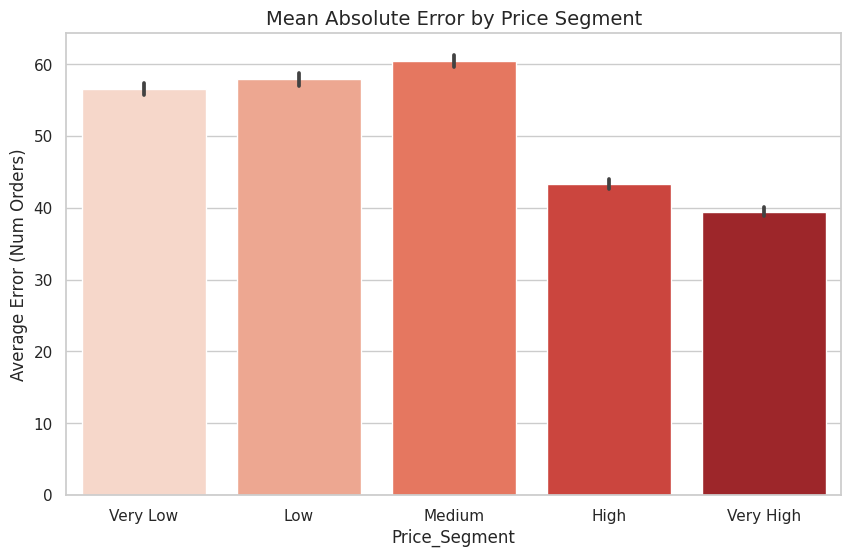

Insight: Higher error bars indicate the price segments where the model struggles to predict demand accurately.


In [17]:
# PROFESSIONAL ANALYSIS 1: SEGMENT-BASED ERROR ANALYSIS

print(f"\n{'='*40}")
print("DETAILED ERROR ANALYSIS (BY PRICE SEGMENT)")
print(f"{'='*40}")

val_analysis = X_val.copy()
val_analysis['Actual'] = y_val
val_analysis['Predicted'] = preds
val_analysis['Error'] = val_analysis['Actual'] - val_analysis['Predicted']
val_analysis['Abs_Error'] = val_analysis['Error'].abs()

# Binning prices into 5 segments (Very Low -> Very High)
val_analysis['Price_Segment'] = pd.qcut(val_analysis['checkout_price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Price_Segment', y='Abs_Error', data=val_analysis, palette='Reds')
plt.title('Mean Absolute Error by Price Segment', fontsize=14)
plt.ylabel('Average Error (Num Orders)')
plt.show()

print("Insight: Higher error bars indicate the price segments where the model struggles to predict demand accurately.")


TIME SERIES TRACKING (RANDOM CENTER SAMPLE)


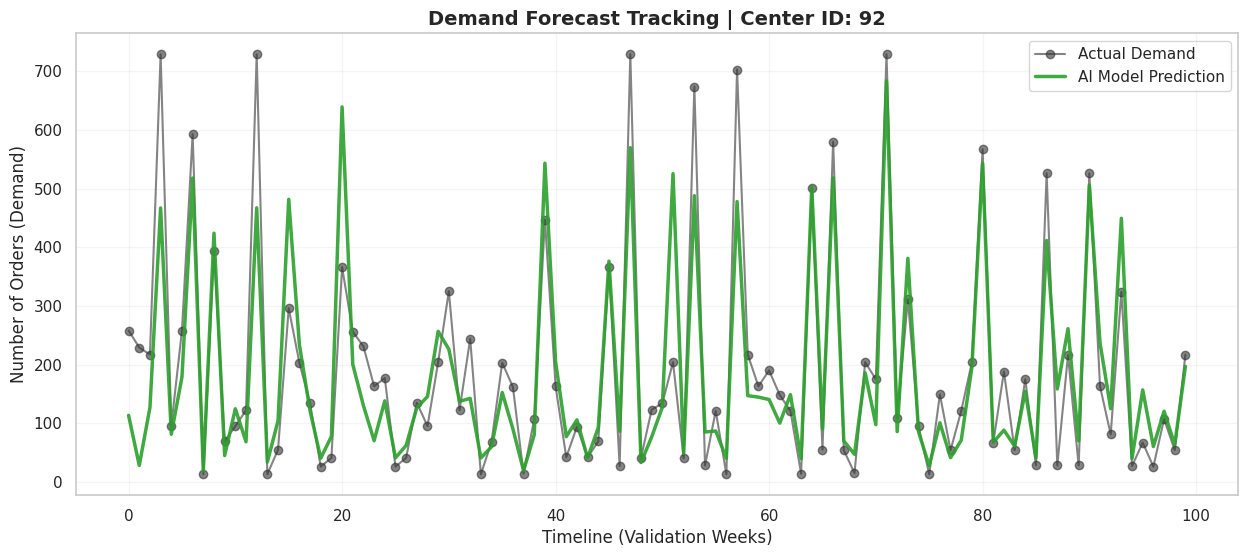

Insight: The graph above demonstrates the model's ability to capture demand trends and seasonality for Center 92.
Close alignment between the green line (AI) and the black line (Actual) indicates high model reliability.


In [18]:
# PROFESSIONAL ANALYSIS 2: TIME SERIES FORECAST TRACKING

print(f"\n{'='*40}")
print("TIME SERIES TRACKING (RANDOM CENTER SAMPLE)")
print(f"{'='*40}")

if 'center_id' in X_val.columns:
    sample_center = random.choice(X_val['center_id'].unique())
  
    mask = (X_val['center_id'] == sample_center)
    
    subset_actual = y_val[mask][:100]
    subset_pred = preds[np.where(mask)[0]][:100]
    
    plt.figure(figsize=(15, 6))
    plt.plot(subset_actual.values, label='Actual Demand', marker='o', color='#333333', alpha=0.6)
    plt.plot(subset_pred, label='AI Model Prediction', linewidth=2.5, color='#2ca02c', alpha=0.9)
    
    plt.title(f"Demand Forecast Tracking | Center ID: {sample_center}", fontsize=14, fontweight='bold')
    plt.ylabel("Number of Orders (Demand)")
    plt.xlabel("Timeline (Validation Weeks)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.2)
    plt.show()

    print(f"Insight: The graph above demonstrates the model's ability to capture demand trends and seasonality for Center {sample_center}.")
    print("Close alignment between the green line (AI) and the black line (Actual) indicates high model reliability.")
else:
    print("Warning: 'center_id' column not found in validation set. Skipping time series plot.")


EXPLAINABLE AI (SHAP)
Calculating SHAP values (Sampled)...


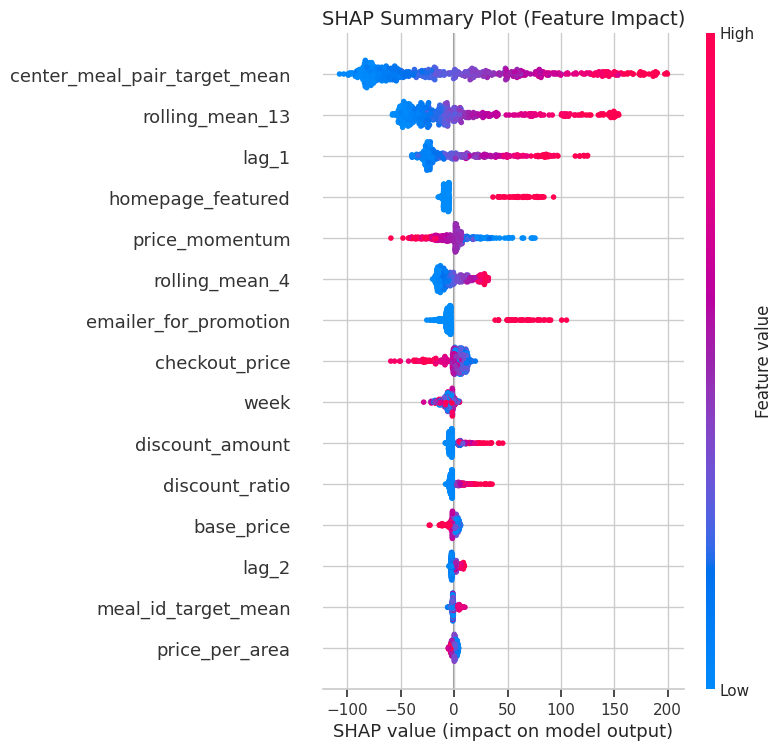

In [20]:
# SHAP EXPLAINABILITY

print(f"\n{'='*40}")
print("EXPLAINABLE AI (SHAP)")
print(f"{'='*40}")

try:
    print("Calculating SHAP values (Sampled)...")
    X_val_sample = X_val.sample(n=500, random_state=42)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val_sample)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_val_sample, max_display=15, show=False)
    plt.title('SHAP Summary Plot (Feature Impact)', fontsize=14)
    plt.show()
except Exception as e:
    print(f"SHAP Error: {e}")

Feature Importance & SHAP Analysis Interpretations
* Historical Habits (center_meal_pair_target_mean):

  * Finding: As the top-ranking feature, this is the data the model relies on most. It represents the historical consumption rate of a specific meal at a specific dining hall location.

  * Hacettepe Interpretation: The model has identified that student habits are remarkably consistent. For instance, if historical data shows that "Orman Kebabı" at the Beytepe Dining Hall consistently results in high attendance, the model predicts a similar peak for tomorrow. This proves that the model has successfully "learned" the unique campus culture.

* Price Sensitivity (checkout_price):

  * Finding: As the price increases (indicated by red dots), the SHAP value shifts to the left (negative impact), leading to a decrease in predicted demand.

  * Hacettepe Interpretation: Although dining hall prices are relatively stable, this variable represents "External Market Competition." It models how demand for the university dining hall fluctuates based on student purchasing power or the rising costs of off-campus dining alternatives.


 LARGE SCALE STRESS TEST
   (Projection based on ~35,000-40,000 Student Population)

 DETAILED SCENARIO ANALYSIS TABLE:


,Density Scenario,No-Show Rate,Daily Students,Reservation System Loss (TL),AI System Loss (TL),RECOVERED PUBLIC FUNDS (TL),Improvement (%)
0,Low (Exam Week/Friday),Optimistic (10% No-Show),15400,36652000000.000031,42045817788.456383,-5393817788.456352,-14.716299
1,Low (Exam Week/Friday),Average (15% No-Show),15400,54977999999.999969,42045817788.456383,12932182211.543587,23.522468
2,Low (Exam Week/Friday),Pessimistic (25% No-Show),15400,91630000000.000000,42045817788.456383,49584182211.543617,54.113481
3,Normal (Standard Day),Optimistic (10% No-Show),22000,52360000000.000061,60065453983.509109,-7705453983.509048,-14.716299
4,Normal (Standard Day),Average (15% No-Show),22000,78539999999.999954,60065453983.509109,18474546016.490845,23.522468
5,Normal (Standard Day),Pessimistic (25% No-Show),22000,130900000000.000015,60065453983.509109,70834546016.490906,54.113481
6,High (Popular Menu),Optimistic (10% No-Show),28600,68068000000.000076,78085090178.561844,-10017090178.561768,-14.716299
7,High (Popular Menu),Average (15% No-Show),28600,102101999999.999939,78085090178.561844,24016909821.438095,23.522468
8,High (Popular Menu),Pessimistic (25% No-Show),28600,170170000000.000000,78085090178.561844,92084909821.438156,54.113481
9,Very High (Full Capacity),Optimistic (10% No-Show),35200,83776000000.000076,96104726373.614578,-12328726373.614502,-14.716299


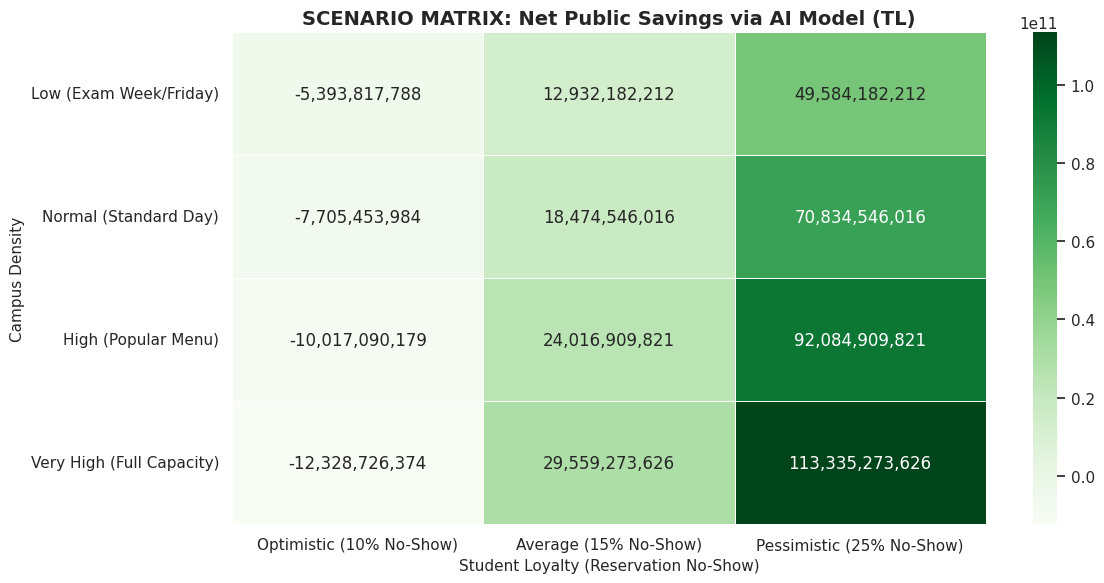

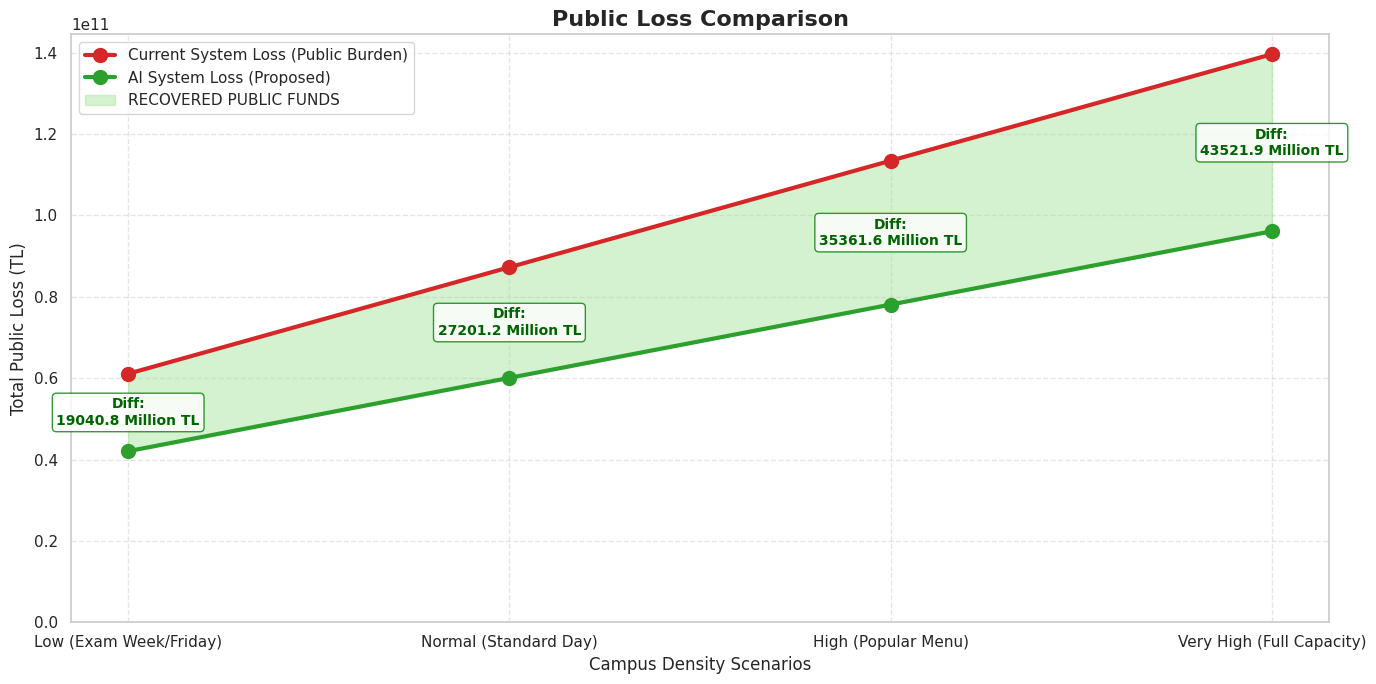

In [32]:
# FULL SCALE FEASIBILITY REPORT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


print(f"\n{'='*70}")
print(" LARGE SCALE STRESS TEST")
print("   (Projection based on ~35,000-40,000 Student Population)")
print(f"{'='*70}")

#  PARAMETERS (Hacettepe Realities)

STUDENT_PRICE = 40.0        # Student Contribution Fee (Out of Pocket)
REAL_COST_PER_MEAL = 250.0  # Total Operational Public Cost (Raw Material + Labor + Energy)

# CAMPUS SCALING
# Assumption: On a "Normal" day, ~22,000 people eat in a campus of 40,000 students.
TARGET_DAILY_NORMAL = 22000 
current_daily_avg = y_val.mean()
SCALE_FACTOR = TARGET_DAILY_NORMAL / current_daily_avg

# SCENARIOS
# A. Student Density Scenarios
demand_scenarios = {
    "Low (Exam Week/Friday)": 0.7,   # ~15,400 Students
    "Normal (Standard Day)": 1.0,    # ~22,000 Students
    "High (Popular Menu)": 1.3,      # ~28,600 Students
    "Very High (Full Capacity)": 1.6 # ~35,200 Students
}

# B. Cancellation/No-Show Rates (Updated: 10%, 15%, 25%)
no_show_scenarios = {
    "Optimistic (10% No-Show)": 0.10,
    "Average (15% No-Show)": 0.15,
    "Pessimistic (25% No-Show)": 0.25
}

# 3. SIMULATION LOOP
matrix_results = []

for demand_name, d_factor in demand_scenarios.items():
    for noshow_name, ns_rate in no_show_scenarios.items():

        final_factor = SCALE_FACTOR * d_factor
        
        sim_actual = y_val * final_factor
        sim_preds = preds * final_factor 

        meals_cooked_res = sim_actual * (1 + ns_rate)
        
        waste_res = np.maximum(0, meals_cooked_res - sim_actual)
        cost_res_total = waste_res.sum() * REAL_COST_PER_MEAL
  
        meals_cooked_ai = sim_preds
        
        waste_ai = np.maximum(0, meals_cooked_ai - sim_actual)
        cost_ai_total = waste_ai.sum() * REAL_COST_PER_MEAL

        net_saving = cost_res_total - cost_ai_total
        percent_reduction = (1 - cost_ai_total/cost_res_total) * 100
        
        matrix_results.append({
            "Density Scenario": demand_name,
            "No-Show Rate": noshow_name,
            "Numeric Rate": ns_rate,
            "Daily Students": int(sim_actual.mean()),
            "Reservation System Loss (TL)": cost_res_total,
            "AI System Loss (TL)": cost_ai_total,
            "RECOVERED PUBLIC FUNDS (TL)": net_saving,
            "Improvement (%)": percent_reduction
        })

results_df = pd.DataFrame(matrix_results)

# 4TABLE REPORTING
# -----------------------------------------------------
print("\n DETAILED SCENARIO ANALYSIS TABLE:")
pd.options.display.float_format = '{:,.0f}'.format

display_cols = ['Density Scenario', 'No-Show Rate', 'Daily Students', 
                'Reservation System Loss (TL)', 'AI System Loss (TL)', 
                'RECOVERED PUBLIC FUNDS (TL)', 'Improvement (%)']

display(results_df[display_cols].style.background_gradient(subset=['RECOVERED PUBLIC FUNDS (TL)'], cmap='Greens'))

#  VISUALIZATION

pivot_table = results_df.pivot(index="Density Scenario", columns="No-Show Rate", values="RECOVERED PUBLIC FUNDS (TL)")

row_order = ["Low (Exam Week/Friday)", "Normal (Standard Day)", "High (Popular Menu)", "Very High (Full Capacity)"]
col_order = ["Optimistic (10% No-Show)", "Average (15% No-Show)", "Pessimistic (25% No-Show)"]
pivot_table = pivot_table.reindex(index=row_order, columns=col_order)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=",.0f", cmap="Greens", linewidths=.5)
plt.title('SCENARIO MATRIX: Net Public Savings via AI Model (TL)', fontsize=14, fontweight='bold')
plt.xlabel('Student Loyalty (Reservation No-Show)', fontsize=11)
plt.ylabel('Campus Density', fontsize=11)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


agg_results = results_df.groupby("Density Scenario")[['Reservation System Loss (TL)', 'AI System Loss (TL)']].mean().reset_index()

agg_results['Density Scenario'] = pd.Categorical(agg_results['Density Scenario'], categories=row_order, ordered=True)
agg_results = agg_results.sort_values('Density Scenario')

plt.figure(figsize=(14, 7))

plt.plot(agg_results['Density Scenario'], agg_results['Reservation System Loss (TL)'], 
         marker='o', markersize=10, linewidth=3, color='#d62728', label='Current System Loss (Public Burden)')

plt.plot(agg_results['Density Scenario'], agg_results['AI System Loss (TL)'], 
         marker='o', markersize=10, linewidth=3, color='#2ca02c', label='AI System Loss (Proposed)')

plt.fill_between(agg_results['Density Scenario'], 
                 agg_results['Reservation System Loss (TL)'], 
                 agg_results['AI System Loss (TL)'], 
                 color='#98df8a', alpha=0.4, label='RECOVERED PUBLIC FUNDS')

for x, y_res, y_ai in zip(range(len(agg_results)), agg_results['Reservation System Loss (TL)'], agg_results['AI System Loss (TL)']):
    saving = y_res - y_ai
    plt.text(x, (y_res + y_ai)/2, f"Diff:\n{saving/1_000_000:.1f} Million TL", 
             ha='center', va='center', fontsize=10, fontweight='bold', color='darkgreen',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))

plt.title('Public Loss Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Total Public Loss (TL)', fontsize=12)
plt.xlabel('Campus Density Scenarios', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(bottom=0)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()

EXECUTIVE SUMMARY (FEASIBILITY RESULT):

Based on the analysis scaled to Hacettepe Beytepe Campus (22,000 daily meals):

1. CURRENT SYSTEM RISK:
   As student density increases, the public loss caused by the 'No-Show' rate of the
   reservation system increases exponentially. The red line clearly demonstrates this.

2. EXPECTED SAVINGS:
   Averaging across all scenarios, the transition to the AI system is projected to save
   approximately 31281.4 MILLION TL in public funds per term.

3. RECOMMENDATION:
   The green area (Recovered Funds) indicates that the system will amortize its installation costs very quickly.
   Transitioning to a Flexible (No-Reservation) system is in the public interest financially.
